In [38]:
import gpflow as gpf
import numpy as np
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, Markdown, Latex
tf.logging.set_verbosity(tf.logging.FATAL)
plt.style.use("slides")

## Generate fake noisey 2-D point robot with input velocities

In [39]:
class NoisyLinearModel2D:
    
    def __init__(self, A, B, C, cov):
        self.A = A
        self.B = B
        self.C = C
        self.cov = cov 
        
    def fwd(self, x, u):
        return self.A @ x + self.B @ u + self.C

    def fwd_w_noise(self, x, u):
        n = self.cov.shape[0]
        return self.fwd(x, u) + np.random.multivariate_normal(np.zeros(n), self.cov)
    
    def display(self):
        print('A=',self.A)
        print('B=',self.B)
        print('C=',self.C)
        print('cov=',self.cov)

In [40]:
A = np.array([[1.0,0.2],[0.0,1.0]], dtype=np.float64)
B = np.array([[0.4, 0.05],[0.05, 0.4]], dtype=np.float64)
C = np.array([0.0, 0.0], dtype=np.float64)
cov = np.array([[0.02,0],[0,0.02]], dtype=np.float64)
true_model = NoisyLinearModel2D(A, B, C, cov)
true_model.display()

A= [[1.  0.2]
 [0.  1. ]]
B= [[0.4  0.05]
 [0.05 0.4 ]]
C= [0. 0.]
cov= [[0.02 0.  ]
 [0.   0.02]]


In [41]:
train_n = 10
np.random.seed(0)
train_x = np.random.uniform(-5, 5, size=(train_n, 2)).astype(np.float64)
train_u = np.random.randn(train_n, 2).astype(np.float64) * 5.0 + 1.0
train_y = np.empty_like(train_x, dtype=np.float64)
for i in range(train_n):
    train_y[i] = true_model.fwd_w_noise(train_x[i], train_u[i])
combined_train_x = np.concatenate((train_x, train_u), axis=1)
    
test_x = np.mgrid[-6:6:3, -6:6:3].reshape(2, -1).T
test_n = test_x.shape[0]
test_u = np.random.randn(test_n, 2).astype(np.float64) * 5.0 + 1.0
test_y = np.empty_like(test_x, dtype=np.float64)
for i in range(test_n):
    test_y[i] = true_model.fwd_w_noise(test_x[i], test_u[i])
combined_test_x = np.concatenate((test_x, test_u), axis=1)

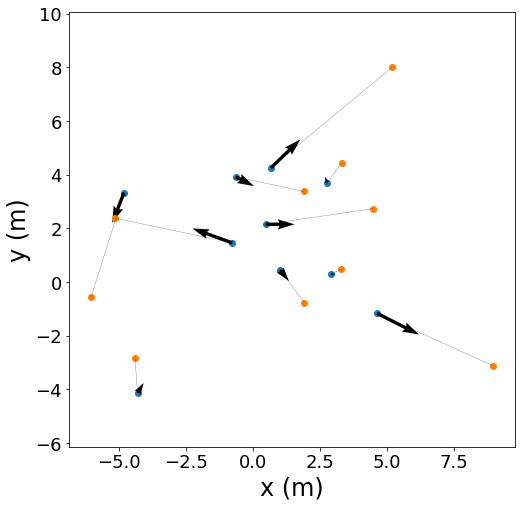

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(train_x[:, 0], train_x[:, 1], label='x')
plt.quiver(train_x[:, 0], train_x[:, 1], train_u[:,0], train_u[:,1], label='u')
plt.scatter(train_y[:, 0], train_y[:, 1], label='y')
for train_x_i, train_y_i in zip(train_x, train_y):
    plt.plot([train_x_i[0], train_y_i[0]], [train_x_i[1], train_y_i[1]], color='k', linewidth=0.2)
plt.axis("equal")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

### Train one multi-output GP

In [43]:
gpf.reset_default_graph_and_session()
k = gpf.kernels.RBF(4, ARD=True)
# k = gpf.kernels.Constant(input_dim=4)
# mean = None
mean = gpf.mean_functions.Linear(np.random.randn(4,2), np.zeros((2)))
m = gpf.models.GPR(combined_train_x, train_y, kern=k, mean_function=mean)
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(4,)",True,"[1.0, 1.0, 1.0, 1.0]"
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
GPR/mean_function/A,Parameter,None,(none),True,"(4, 2)",True,"[[0.37642553115562943, -1.0994007905841945], [..."
GPR/mean_function/b,Parameter,None,(none),True,"(2,)",True,"[0.0, 0.0]"


In [44]:
def plot_test(model, title=''):
    pred_y_mean = model.predict_f(combined_test_x)[0]
    plt.figure(figsize=(5,5))
    plt.title(title)
    plt.scatter(test_x[:, 0], test_x[:, 1], label='label x')
    plt.quiver(test_x[:, 0], test_x[:, 1], test_u[:,0], test_u[:,1], label='u')
    plt.scatter(test_y[:, 0], test_y[:, 1], label='label y')
    for test_x_i, test_y_i in zip(test_x, test_y):
        plt.plot([test_x_i[0], test_y_i[0]], [test_x_i[1], test_y_i[1]], color='k', linewidth=0.2)
    plt.scatter(pred_y_mean[:, 0], pred_y_mean[:, 1], label='pred y')
    for test_x_i, pred_y_mean_i in zip(test_x, pred_y_mean):
        plt.plot([test_x_i[0], pred_y_mean_i[0]], [test_x_i[1], pred_y_mean_i[1]], color='k', linewidth=0.2)
    plt.axis("equal")
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")

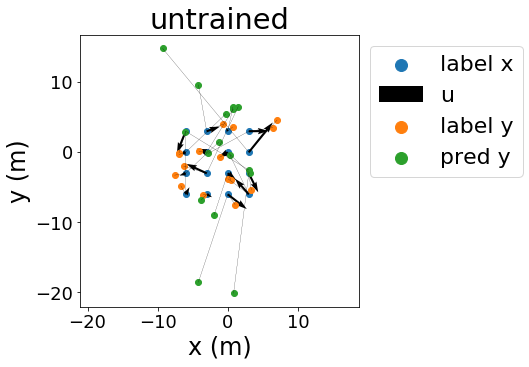

In [45]:
plot_test(m, 'untrained')

In [46]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m);
display(m.as_pandas_table())
print('A=', m.mean_function.A.value[:2].T)
print('B=', m.mean_function.A.value[2:].T)
print('C=', m.mean_function.b.value)

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(4,)",True,"[1.000065190309058, 1.0000119824960274, 1.0000..."
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.006624769262570118
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.006624696897762364
GPR/mean_function/A,Parameter,None,(none),True,"(4, 2)",True,"[[1.003838835840708, -0.003225654615268039], [..."
GPR/mean_function/b,Parameter,None,(none),True,"(2,)",True,"[-0.0989995132760309, -0.01867372964710004]"


A= [[ 1.00383884  0.19853627]
 [-0.00322565  1.0066765 ]]
B= [[0.40124329 0.04429137]
 [0.06149764 0.40368689]]
C= [-0.09899951 -0.01867373]


In [47]:
true_model.display()

A= [[1.  0.2]
 [0.  1. ]]
B= [[0.4  0.05]
 [0.05 0.4 ]]
C= [0. 0.]
cov= [[0.02 0.  ]
 [0.   0.02]]


In [48]:
m.compute_log_likelihood()

14.85920048366477

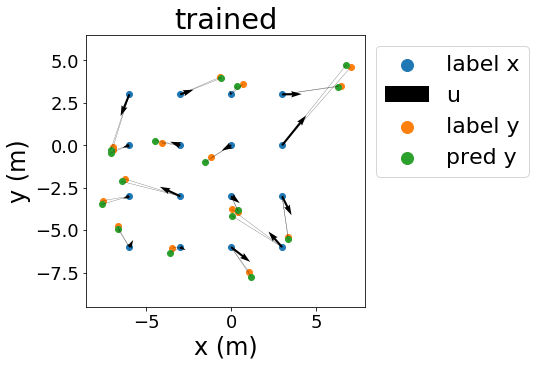

In [49]:
plot_test(m, 'trained')


In [50]:
%%timeit
m.predict_f(combined_test_x[0:1])

1.1 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Do long-term prediction with exact moment matching

This works by starting off with some distribution $\tilde{x_1}$ which in this case consists of a point in 2D $x_1$ plus a control input $u_1$,
then put it through the GP and get a gaussian distribution out, described by some mean $\mu_{\Delta}$ and covariance $\Sigma_{\Delta}$, for the change in 2D position.
The variable $\Delta_t$ is the label (y-value) which is the delta 2D position.
The equations for computing the guassian approximation of the next step are:

$$
\begin{align}
 \tilde{x}_1 &= [x_t^T u_t^T]^T \\
\tilde{x}_1 &\sim \mathcal{N}(\mu_1, \Sigma_1) \\
u_1 &~ \mathcal{N}(\mu_1, \Sigma_1) \\
\mu_2 &= \mu_1 + \mu_{\Delta} \\
\Sigma_2 &= \Sigma_1 + \Sigma_{\Delta} + cov(x_1, \Delta_t) + cov(\Delta_t, x_1) \\
cov(x_1, \Delta_t) &= cov(x_1, u_1)\Sigma_u^{-1}cov(u_1, \Delta_t) \\
cov(x_1, u_1) &= \mathbb{E}[(x_1 - \mathbb{E}[x_1])(u_1 - \mathbb{E}[u_1])^T]
\end{align}
$$